In [50]:
!pip install -U xgboost -f /kaggle/input/xgboost-python-package/ --no-index

Looking in links: /kaggle/input/xgboost-python-package/


In [51]:
import numpy as np
import pandas as pd
import json

import seaborn as sns
import matplotlib.pyplot as plt
from colorama import Fore, Style, init;
from sklearn.metrics import mean_squared_error

import xgboost as xgb
import lightgbm as lgb
import torch

#Geolocation
from geopy.geocoders import Nominatim

pd.set_option('display.max_columns', 100)
DEBUG=False

# using GPU or CPU for training
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

# **1. Dataset preparation**

In [52]:
# just some coloring and printing functions
# first one prints the size and first row of the dataset
# second one is just coloring
def display_df(df, name):
    PrintColor(text = f'{name} data has {df.shape[0]} rows and {df.shape[1]} columns. \n ===> First row:')
    display(df.head(1))

def PrintColor(text:str, color = Fore.BLUE, style = Style.BRIGHT):
    print(style + color + text + Style.RESET_ALL); 

In [53]:
# just reading all datasets
train = pd.read_csv("/kaggle/input/predict-energy-behavior-of-prosumers/train.csv")
client = pd.read_csv("/kaggle/input/predict-energy-behavior-of-prosumers/client.csv")
historical_weather = pd.read_csv("/kaggle/input/predict-energy-behavior-of-prosumers/historical_weather.csv")
forecast_weather = pd.read_csv("/kaggle/input/predict-energy-behavior-of-prosumers/forecast_weather.csv")
electricity = pd.read_csv("/kaggle/input/predict-energy-behavior-of-prosumers/electricity_prices.csv")
gas = pd.read_csv("/kaggle/input/predict-energy-behavior-of-prosumers/gas_prices.csv")
location = pd.read_csv("/kaggle/input/fabiendaniels-mapping-locations-and-county-codes/county_lon_lats.csv").drop(columns=["Unnamed: 0"])

# open the county id to name file (json format)
with open("/kaggle/input/predict-energy-behavior-of-prosumers/county_id_to_name_map.json") as f:
    county_codes = json.load(f)

# using the coloring and printing functions to show datasets
display_df(train, "train")
display_df(client, "client")
display_df(historical_weather, "historical_weather")
display_df(forecast_weather, "forecast_weather")
display_df(electricity, "electricity")
display_df(gas, "gas")
display_df(location, "location")
pd.DataFrame(county_codes, index=[0])

train data has 2018352 rows and 9 columns. 
 ===> First row:


,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id
0,0,0,1,0.713,0,2021-09-01 00:00:00,0,0,0


client data has 41919 rows and 7 columns. 
 ===> First row:


,product_type,county,eic_count,installed_capacity,is_business,date,data_block_id
0,1,0,108,952.89,0,2021-09-01,2


historical_weather data has 1710802 rows and 18 columns. 
 ===> First row:


,datetime,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation,diffuse_radiation,latitude,longitude,data_block_id
0,2021-09-01 00:00:00,14.2,11.6,0.0,0.0,1015.9,31,31,0,11,7.083333,8,0.0,0.0,0.0,57.6,21.7,1.0


forecast_weather data has 3424512 rows and 18 columns. 
 ===> First row:


,latitude,longitude,origin_datetime,hours_ahead,temperature,dewpoint,cloudcover_high,cloudcover_low,cloudcover_mid,cloudcover_total,10_metre_u_wind_component,10_metre_v_wind_component,data_block_id,forecast_datetime,direct_solar_radiation,surface_solar_radiation_downwards,snowfall,total_precipitation
0,57.6,21.7,2021-09-01 02:00:00,1,15.655786,11.553613,0.904816,0.019714,0.0,0.905899,-0.411328,-9.106137,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0


electricity data has 15286 rows and 4 columns. 
 ===> First row:


,forecast_date,euros_per_mwh,origin_date,data_block_id
0,2021-09-01 00:00:00,92.51,2021-08-31 00:00:00,1


gas data has 637 rows and 5 columns. 
 ===> First row:


,forecast_date,lowest_price_per_mwh,highest_price_per_mwh,origin_date,data_block_id
0,2021-09-01,45.23,46.32,2021-08-31,1


location data has 75 rows and 3 columns. 
 ===> First row:


,county,longitude,latitude
0,0,24.2,59.1


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,HARJUMAA,HIIUMAA,IDA-VIRUMAA,JÄRVAMAA,JÕGEVAMAA,LÄÄNE-VIRUMAA,LÄÄNEMAA,PÄRNUMAA,PÕLVAMAA,RAPLAMAA,SAAREMAA,TARTUMAA,UNKNOWN,VALGAMAA,VILJANDIMAA,VÕRUMAA


In [54]:
class FeatureProcessorClass():
    def __init__(self):         
        # Take columns from different datasets 
        # and combine into one later: weather, client, electricity, gas
        self.weather_join = ['datetime', 'county', 'data_block_id']
        self.gas_join = ['data_block_id']
        self.electricity_join = ['datetime', 'data_block_id']
        self.client_join = ['county', 'is_business', 'product_type', 'data_block_id']
        
        # Columns of latitude & longitude
        self.lat_lon_columns = ['latitude', 'longitude']
        
        # Aggregate stats 
        self.agg_stats = ['mean'] #, 'min', 'max', 'std', 'median']
        
        # Categorical columns (specify for XGBoost)
        self.category_columns = ['county', 'is_business', 'product_type', 'is_consumption', 'data_block_id']

    def create_new_column_names(self, df, suffix, columns_no_change):
        # Change column names by given suffix, check column name
        # if it is not in columns_no_change, change name into col + suffix
        # and return the data
        df.columns = [col + suffix 
                      if col not in columns_no_change
                      else col
                      for col in df.columns
                      ]
        return df 

    def flatten_multi_index_columns(self, df):
        # list A: (if it is not empty) column names
        # list B is the final list: for each column, "_".join(list A)
        df.columns = ['_'.join([col for col in multi_col if len(col)>0]) 
                      for multi_col in df.columns]
        return df
    
    def create_data_features(self, data):
        # format all the datetime
        
        # To datetime
        data['datetime'] = pd.to_datetime(data['datetime'])
        
        # Time period features
        data['date'] = data['datetime'].dt.normalize()
        data['year'] = data['datetime'].dt.year
        data['quarter'] = data['datetime'].dt.quarter
        data['month'] = data['datetime'].dt.month
        data['week'] = data['datetime'].dt.isocalendar().week
        data['hour'] = data['datetime'].dt.hour
        
        # Day features
        data['day_of_year'] = data['datetime'].dt.day_of_year
        data['day_of_month']  = data['datetime'].dt.day
        data['day_of_week'] = data['datetime'].dt.day_of_week
        return data

    def create_client_features(self, client):
        # Apply first two def to change some of the names in client list
        client = self.create_new_column_names(client, 
                                           suffix='_client',
                                           columns_no_change = self.client_join
                                          )       
        return client
    
    def create_historical_weather_features(self, historical_weather):
        # Formuate the datetime
        historical_weather['datetime'] = pd.to_datetime(historical_weather['datetime'])
        
        # Add column county into historical weather
        historical_weather[self.lat_lon_columns] = historical_weather[self.lat_lon_columns].astype(float).round(1)
        historical_weather = historical_weather.merge(location, how = 'left', on = self.lat_lon_columns)

        # Apply first two def to change some of the names in historical weather list
        # the column no change is historical weather + location
        historical_weather = self.create_new_column_names(historical_weather,
                                                          suffix='_h',
                                                          columns_no_change = self.lat_lon_columns + self.weather_join
                                                          ) 
        
        # for column in hist weather, if it is not in the combined list, append into agg_columns
        # make a dict that each col in agg_columns has the agg statistical info: see agg_stat in the first def
        # grouping according to the self.weather_join
        agg_columns = [col for col in historical_weather.columns if col not in self.lat_lon_columns + self.weather_join]
        agg_dict = {agg_col: self.agg_stats for agg_col in agg_columns}
        historical_weather = historical_weather.groupby(self.weather_join).agg(agg_dict).reset_index() 
        
        # Flatten the multi column aggregates
        historical_weather = self.flatten_multi_index_columns(historical_weather) 
        
        # Test set has 1 day offset for hour<11 and 2 day offset for hour>11
        historical_weather['hour_h'] = historical_weather['datetime'].dt.hour
        historical_weather['datetime'] = (historical_weather
                                               .apply(lambda x: 
                                                      x['datetime'] + pd.DateOffset(1) 
                                                      if x['hour_h']< 11 
                                                      else x['datetime'] + pd.DateOffset(2),
                                                      axis=1)
                                              )
        
        return historical_weather
    
    def create_forecast_weather_features(self, forecast_weather):
        # drop the origin_date and rename the columns
        forecast_weather = (forecast_weather
                            .rename(columns = {'forecast_datetime': 'datetime'})
                            .drop(columns = 'origin_datetime')
                           )
        
        # format the datetime
        forecast_weather['datetime'] = (pd.to_datetime(forecast_weather['datetime'])
                                        .dt
                                        .tz_localize(None)
                                       )

        # add county into forecast_weather dataset
        # add the location info into the dataset
        forecast_weather[self.lat_lon_columns] = forecast_weather[self.lat_lon_columns].astype(float).round(1)
        forecast_weather = forecast_weather.merge(location, how = 'left', on = self.lat_lon_columns)
        
        # Apply first two def to change some of the names in forecast weather and lat_lon
        forecast_weather = self.create_new_column_names(forecast_weather,
                                                        suffix='_f',
                                                        columns_no_change = self.lat_lon_columns + self.weather_join
                                                        ) 
        
        # for column in fore. weather, if it is not in the combined list, append into agg_columns
        # make a dict that each col in agg_columns has the agg statistical info: see agg_stat in the first def
        # grouping according to the self.weather_join
        agg_columns = [col for col in forecast_weather.columns if col not in self.lat_lon_columns + self.weather_join]
        agg_dict = {agg_col: self.agg_stats for agg_col in agg_columns}
        forecast_weather = forecast_weather.groupby(self.weather_join).agg(agg_dict).reset_index() 
        
        # Flatten the multi column aggregates
        forecast_weather = self.flatten_multi_index_columns(forecast_weather)     
        return forecast_weather

    def create_electricity_features(self, electricity):
        # Format datetime in electricity
        electricity['forecast_date'] = pd.to_datetime(electricity['forecast_date'])
        
        # Test set has 1 day offset
        electricity['datetime'] = electricity['forecast_date'] + pd.DateOffset(1)
        
        # Apply first two def to change names in electricity
        electricity = self.create_new_column_names(electricity, 
                                                   suffix='_electricity',
                                                   columns_no_change = self.electricity_join
                                                  )             
        return electricity

    def create_gas_features(self, gas):
        # Mean gas price
        gas['mean_price_per_mwh'] = (gas['lowest_price_per_mwh'] + gas['highest_price_per_mwh'])/2
        
        # Apply first two def to change names in gas
        gas = self.create_new_column_names(gas, 
                                           suffix='_gas',
                                           columns_no_change = self.gas_join
                                          )       
        return gas
    
    def __call__(self, data, client, historical_weather, forecast_weather, electricity, gas):
        # Create and prepare features for all dataset
        data = self.create_data_features(data)
        client = self.create_client_features(client)
        historical_weather = self.create_historical_weather_features(historical_weather)
        forecast_weather = self.create_forecast_weather_features(forecast_weather)
        electricity = self.create_electricity_features(electricity)
        gas = self.create_gas_features(gas)
        
        # Now add all dataset into one:
        df = data.merge(client, how='left', on = self.client_join)
        df = df.merge(historical_weather, how='left', on = self.weather_join)
        df = df.merge(forecast_weather, how='left', on = self.weather_join)
        df = df.merge(electricity, how='left', on = self.electricity_join)
        df = df.merge(gas, how='left', on = self.gas_join)
        
        # Change columns to categorical for XGBoost
        df[self.category_columns] = df[self.category_columns].astype('category')
        return df

In [55]:
def create_revealed_targets_train(data, N_day_lags):
    # copy necessary info
    original_datetime = data['datetime']
    revealed_targets = data[['datetime', 'prediction_unit_id', 'is_consumption', 'target']].copy()
    
    # first calculate the 
    for day_lag in range(2, N_day_lags+1):
        revealed_targets['datetime'] = original_datetime + pd.DateOffset(day_lag)
        # now keep the original and using on ="List" as pivot
        # only add target_days_ago (original is left)
        data = data.merge(revealed_targets, 
                          how='left', 
                          on = ['datetime', 'prediction_unit_id', 'is_consumption'],
                          suffixes = ('', f'_{day_lag}_days_ago')
                         )
    return data

In [56]:
# control the number of days to train (at least 2 days)
N_day_lags = 15

# using the feature processor (2 cells above) and function (a cell above) to prepare a dataset
FeatureProcessor = FeatureProcessorClass()

data = FeatureProcessor(data = train.copy(),
                      client = client.copy(),
                      historical_weather = historical_weather.copy(),
                      forecast_weather = forecast_weather.copy(),
                      electricity = electricity.copy(),
                      gas = gas.copy(),
                     )

df = create_revealed_targets_train(data.copy(), N_day_lags = N_day_lags)

In [57]:
target = "target"
# cleaning, ditch null in target & reset index
df = df[df[target].notnull()].reset_index(drop=True)

train_block_id = list(range(0, 500))

# first 500 data_block_ids are used for training, if the 
# data_block_id IS IN the list, then it is train set, or else test set
tr = df[df["data_block_id"].isin(train_block_id)]

#others are for validation
val = df[~df["data_block_id"].isin(train_block_id)]

print('The shape of training set:', tr.shape)
print('The shape of validation set:', val.shape)
print(f'About {len(tr)/(len(tr)+len(val)):.2%} of the data are used for training while the rest is for validation.')

The shape of training set: (1578996, 71)
The shape of validation set: (438828, 71)
About 78.25% of the data are used for training while the rest is for validation.


In [58]:
no_features = ['date', 
                'latitude', 
                'longitude', 
                'data_block_id', 
                'row_id',
                'hours_ahead',
                'hour_h',
               ]

remove_columns = []
features = []

# prepare the feature we want to use, delete the unnecessary ones:
# gather the columns in df that is unnecessary for analysis
for col in df.columns:
    for no_feature in no_features:
        if no_feature in col:
            remove_columns.append(col)

remove_columns.append(target)

# extract the feature that is necessary
for col in df.columns:
    if col not in remove_columns:
        features.append(col)

# turing dtype of week from UInt32 to int32
tr=tr.astype({"week": np.int32})
val=val.astype({"week": np.int32})

print("There are", len(features), "features at the end. They are:\n")
print(features)

There are 59 features at the end. They are:

['county', 'is_business', 'product_type', 'is_consumption', 'prediction_unit_id', 'year', 'quarter', 'month', 'week', 'hour', 'day_of_year', 'day_of_month', 'day_of_week', 'eic_count_client', 'installed_capacity_client', 'temperature_h_mean', 'dewpoint_h_mean', 'rain_h_mean', 'snowfall_h_mean', 'surface_pressure_h_mean', 'cloudcover_total_h_mean', 'cloudcover_low_h_mean', 'cloudcover_mid_h_mean', 'cloudcover_high_h_mean', 'windspeed_10m_h_mean', 'winddirection_10m_h_mean', 'shortwave_radiation_h_mean', 'direct_solar_radiation_h_mean', 'diffuse_radiation_h_mean', 'temperature_f_mean', 'dewpoint_f_mean', 'cloudcover_high_f_mean', 'cloudcover_low_f_mean', 'cloudcover_mid_f_mean', 'cloudcover_total_f_mean', '10_metre_u_wind_component_f_mean', '10_metre_v_wind_component_f_mean', 'direct_solar_radiation_f_mean', 'surface_solar_radiation_downwards_f_mean', 'snowfall_f_mean', 'total_precipitation_f_mean', 'euros_per_mwh_electricity', 'lowest_price_p

# **2. XGBoost approach**

In [59]:
%%time
# set up xgb
xgb_reg = xgb.XGBRegressor(device = device, enable_categorical=True, objective = "reg:absoluteerror", n_estimators = 2 if DEBUG else 1500, early_stopping_rounds=100)
# fitting
xgb_reg.fit(X = tr[features], y = tr[target], eval_set = [(tr[features], tr[target]), (val[features], val[target])], verbose=True)

[0]	validation_0-mae:230.93961	validation_1-mae:305.27014
[1]	validation_0-mae:205.76051	validation_1-mae:275.20860
[2]	validation_0-mae:181.70863	validation_1-mae:245.86677
[3]	validation_0-mae:161.12005	validation_1-mae:219.49207
[4]	validation_0-mae:145.65646	validation_1-mae:199.33874
[5]	validation_0-mae:133.53556	validation_1-mae:183.82314
[6]	validation_0-mae:116.92307	validation_1-mae:161.49621
[7]	validation_0-mae:98.19209	validation_1-mae:139.40756
[8]	validation_0-mae:84.30572	validation_1-mae:122.33296
[9]	validation_0-mae:75.17159	validation_1-mae:109.87843
[10]	validation_0-mae:68.83039	validation_1-mae:101.25286
[11]	validation_0-mae:64.21075	validation_1-mae:94.76007
[12]	validation_0-mae:60.91574	validation_1-mae:89.12800
[13]	validation_0-mae:58.54516	validation_1-mae:85.53485
[14]	validation_0-mae:57.62083	validation_1-mae:84.35581
[15]	validation_0-mae:56.62405	validation_1-mae:82.90245
[16]	validation_0-mae:55.63968	validation_1-mae:81.55719
[17]	validation_0-mae:5

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='cpu', early_stopping_rounds=100,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1500, n_jobs=None,
             num_parallel_tree=None, objective='reg:absoluteerror', ...)

Early stopping on best iteration # 278 with MAE error on validation set of 61.55103719709811


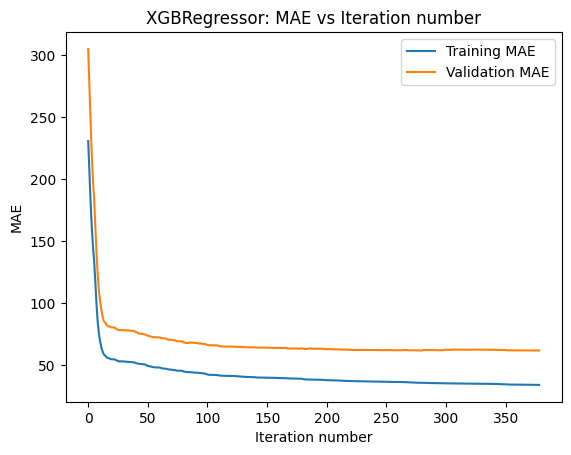

In [60]:
# print the best iteration that has smallest MAE
print('Early stopping on best iteration #', xgb_reg.best_iteration, 'with MAE error on validation set of', xgb_reg.best_score)

# plotting both training and validation MAE
results = xgb_reg.evals_result_
train_mae, val_mae = results['validation_0']["mae"], results['validation_1']["mae"]
itern=list(range(len(train_mae)))

plt.plot(itern, train_mae, label="Training MAE")
plt.plot(itern, val_mae, label="Validation MAE")
plt.title("XGBRegressor: MAE vs Iteration number")
plt.xlabel("Iteration number")
plt.ylabel("MAE")
plt.legend()
plt.show()

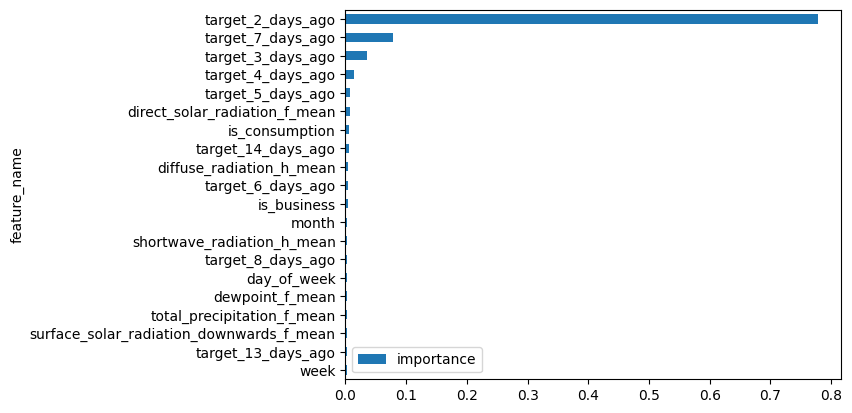

In [61]:
# plotting the top 20 important features
# starting from the most important one
data_imp = pd.DataFrame({"feature_name": xgb_reg.feature_names_in_, "importance": xgb_reg.feature_importances_})
data_imp

sorted_data_imp = data_imp.sort_values(by="importance", ascending=False)[:20].plot.barh(y="importance", x="feature_name", label = "importance")
sorted_data_imp.invert_yaxis()

# **3. LightBGM approach**

In [62]:
%%time
# set up lgb
gbm_reg = lgb.LGBMRegressor(objecive= "regression_l1", n_estimators = 2 if DEBUG else 1500, early_stopping_rounds = 100)
# fitting
gbm_reg.fit(tr[features], tr[target], eval_set = [(tr[features], tr[target]), (val[features], val[target])], eval_metric="mae")

/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	valid_0's l1: 316.586	valid_0's l2: 618207	valid_1's l1: 360.045	valid_1's l2: 895813
[2]	valid_0's l1: 287.68	valid_0's l2: 508155	valid_1's l1: 327.195	valid_1's l2: 737000
[3]	valid_0's l1: 261.584	valid_0's l2: 418919	valid_1's l1: 297.592	valid_1's l2: 608363
[4]	valid_0's l1: 238.238	valid_0's l2: 346562	valid_1's l1: 271.284	valid_1's l2: 505420
[5]	valid_0's l1: 217.497	valid_0's l2: 287621	valid_1's l1: 247.691	valid_1's l2: 418708
[6]	valid_0's l1: 198.912	valid_0's l2: 239682	valid_1's l1: 226.911	valid_1's l2: 351208
[7]	valid_0's l1: 182.196	valid_0's l2: 200607	valid_1's l1: 208.158	valid_1's l2: 295901
[8]	valid_0's l1: 167.236	valid_0's l2: 168785	valid_1's l1: 191.296	valid_1's l2: 249591
[9]	valid_0's l1: 153.8	valid_0's l2: 142764	valid_1's l1: 176.29	valid_1's l2: 213041
[10]	valid_0's l1: 141.934	valid_0's l2: 121587	valid_1's l1: 163.269	valid_1's l2: 184086
[11]	valid_0's l1: 131.271	valid_0's l2: 104208	valid_1's l1: 151.517	valid_1's l2: 159771
[12]	valid_0

LGBMRegressor(early_stopping_rounds=100, n_estimators=1500,
              objecive='regression_l1')

Early stopping on best iteration # 489 with MAE error on validation set of 62.77189839039556


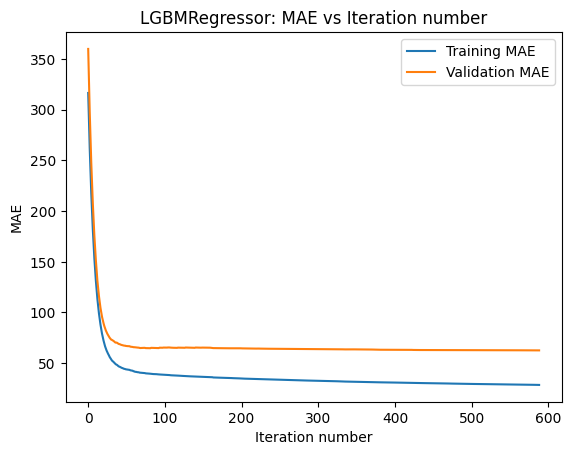

In [63]:
# print the best iteration that has smallest MAE
print('Early stopping on best iteration #', gbm_reg.best_iteration_, 'with MAE error on validation set of', gbm_reg.best_score_['valid_1']['l1'])

# plotting both training and validation MAE
results2 = gbm_reg.evals_result_
train2_mae, val2_mae = results2['valid_0']["l1"], results2['valid_1']["l1"]
itern2=list(range(len(train2_mae)))

plt.plot(itern2, train2_mae, label="Training MAE")
plt.plot(itern2, val2_mae, label="Validation MAE")
plt.title("LGBMRegressor: MAE vs Iteration number")
plt.xlabel("Iteration number")
plt.ylabel("MAE")
plt.legend()
plt.show()

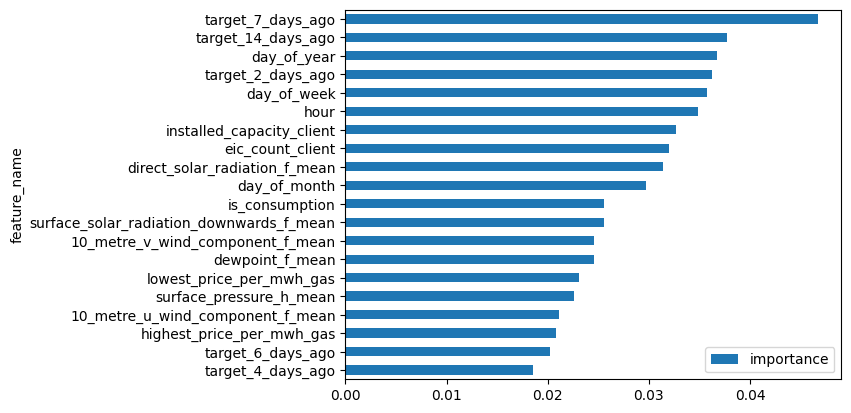

In [64]:
# plotting the top 20 important features
# starting from the most important one
# normalized before showing
gbm_reg_imp=gbm_reg.feature_importances_/np.sum(gbm_reg.feature_importances_)
data_imp2 = pd.DataFrame({"feature_name": gbm_reg.feature_name_, "importance": gbm_reg_imp})
data_imp2

sorted_data_imp2 = data_imp2.sort_values(by="importance", ascending=False)[:20].plot.barh(y="importance", x="feature_name", label = "importance")
sorted_data_imp2.invert_yaxis()